<a href="https://colab.research.google.com/github/jacmal/YELP_Reviews/blob/main/YELP_Reviews_Bayes_NLP_Classyfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIBRARIES IMPORT

In [1]:
import requests
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix

#LOAD DATASET

In [2]:
# URL link
url="https://raw.githubusercontent.com/jacmal/YELP_Reviews/main/yelp.csv"
site = requests.get(url).content

df = pd.read_csv(io.StringIO(site.decode('utf-8')))
df.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0


#DATA SET ANALYSIS

In [3]:
df.shape

(10000, 10)

In [4]:
df.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [6]:
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [7]:
# first review sample text
df['text'][0]

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

In [8]:
# create new DataFrame with text column only
reviews_text = df['text']
reviews_text.head()

0    My wife took me here on my birthday for breakf...
1    I have no idea why some people give bad review...
2    love the gyro plate. Rice is so good and I als...
3    Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4    General Manager Scott Petello is a good egg!!!...
Name: text, dtype: object

In [9]:
# number of reviews on each business comp.
number_of_businesses_reviews = df['business_id'].value_counts()
# number of companies 
number_of_businesses = len(number_of_businesses_reviews)

print("Businesses: ",number_of_businesses)
print("")
print(number_of_businesses_reviews)

Businesses:  4174

ntN85eu27C04nwyPa8IHtw    37
JokKtdXU7zXHcr20Lrk29A    37
hW0Ne_HTHEAgGF1rAdmR-g    34
WNy1uzcmm_UHmTyR--o5IA    32
VVeogjZya58oiTxK7qUjAQ    31
                          ..
qFPJ_bHbS13PoEEKNexnBQ     1
sDXXYFW9vhprUXa4b1jvWg     1
YDyN11CdbO0ZwTlPwa5KnA     1
ITcg0ABneVKWREfzx7v7Og     1
z3zcsnK26QhC7TqDX73zvA     1
Name: business_id, Length: 4174, dtype: int64


In [10]:
df['type'].value_counts()

review    10000
Name: type, dtype: int64

#VISUALIZE DATASET

In [11]:
# add new column with the number of characters in the text of each review
df['length'] = df['text'].apply(len)
df.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345


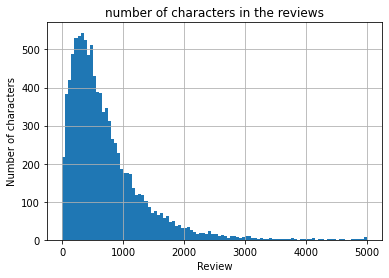

In [12]:
# create histogram with the number of characters in the text of each review
df['length'].hist(bins=100)
plt.title('number of characters in the reviews')
plt.xlabel('Review')
plt.ylabel('Number of characters')
plt.show();

In [13]:
# 
df['length'].describe()

count    10000.000000
mean       710.738700
std        617.399827
min          1.000000
25%        294.000000
50%        541.500000
75%        930.000000
max       4997.000000
Name: length, dtype: float64

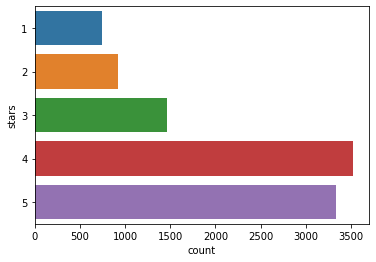

In [14]:
# create countplot for each rating class
sns.countplot(data=df, y='stars'); 

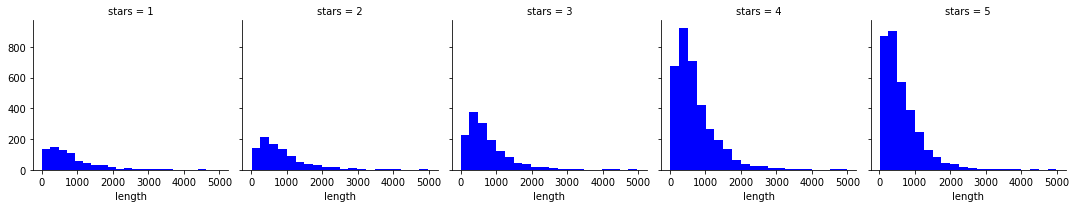

In [15]:
# create a review length histogram for each of the 5 classes of grades  
grid = sns.FacetGrid(data=df, col='stars', col_wrap=5)
grid.map(plt.hist, 'length', bins=20, color='blue');

#TEXT PREPROCESSING

In [16]:
# download english stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# print english language stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
def text_cleaner(text):
  '''
  Function take string variable and remove punctuation.
  '''
  
  # builds a list without punctuation 
  text_punc_removed = [char for char in text if char not in string.punctuation]
  
  # combines words from a list into a complete text 
  text_punc_removed_join = ''.join(text_punc_removed)
  
  # create a list without English stopwords and changes letters into lowercase
  text_punc_removed_join_clean = [word for word in text_punc_removed_join.split() if word.lower() not in stopwords.words('english')]

  return text_punc_removed_join_clean

In [19]:
# first review sample raw text
df['text'][0]

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

In [20]:
# first review text after cleaning
sample_string = df['text'][0]
clean_sample = text_cleaner(sample_string)
clean_sample

['wife',
 'took',
 'birthday',
 'breakfast',
 'excellent',
 'weather',
 'perfect',
 'made',
 'sitting',
 'outside',
 'overlooking',
 'grounds',
 'absolute',
 'pleasure',
 'waitress',
 'excellent',
 'food',
 'arrived',
 'quickly',
 'semibusy',
 'Saturday',
 'morning',
 'looked',
 'like',
 'place',
 'fills',
 'pretty',
 'quickly',
 'earlier',
 'get',
 'better',
 'favor',
 'get',
 'Bloody',
 'Mary',
 'phenomenal',
 'simply',
 'best',
 'Ive',
 'ever',
 'Im',
 'pretty',
 'sure',
 'use',
 'ingredients',
 'garden',
 'blend',
 'fresh',
 'order',
 'amazing',
 'EVERYTHING',
 'menu',
 'looks',
 'excellent',
 'white',
 'truffle',
 'scrambled',
 'eggs',
 'vegetable',
 'skillet',
 'tasty',
 'delicious',
 'came',
 '2',
 'pieces',
 'griddled',
 'bread',
 'amazing',
 'absolutely',
 'made',
 'meal',
 'complete',
 'best',
 'toast',
 'Ive',
 'ever',
 'Anyway',
 'cant',
 'wait',
 'go',
 'back']

In [21]:
# apply "text_cleaner" function on all column with reviews
df['text_clean'] = df['text'].apply(text_cleaner)
#df['text_clean'][0]

#TEXT COUNT VECTORIZATION

In [22]:
# create two DataFrames 
# negative reviews
df_1 = df[df['stars'] == 1]
# second with positive
df_5 = df[df['stars'] == 5]

In [23]:
print("Reviews NEGATIVE: ",len(df_1))
print("Reviews POSITIVE: ",len(df_5))

Reviews NEGATIVE:  749
Reviews POSITIVE:  3337


In [24]:
# create a new DataFrame with only two classes of reviews
df_1_5 = pd.concat([df_1, df_5])
df_1_5.shape

(4086, 12)

In [25]:
# cleaning and transforming text revies into count vectorized form
vectorizer = CountVectorizer(analyzer=text_cleaner)
text_countvectorizer = vectorizer.fit_transform(df_1_5['text'])

In [26]:
text_countvectorizer.shape

(4086, 26435)

In [27]:
vectorizer.get_feature_names()

['0',
 '00s',
 '01042012',
 '022010',
 '03342',
 '05',
 '050',
 '06',
 '07092008',
 '075',
 '09',
 '090',
 '095',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '1000am',
 '1000pm',
 '1000x',
 '1001',
 '100150',
 '1007',
 '100s',
 '100th',
 '101',
 '1011',
 '1012',
 '101412',
 '1015',
 '102',
 '1025',
 '1030',
 '103011',
 '1030pm',
 '10312012',
 '105',
 '105°',
 '1070',
 '108',
 '109',
 '1095',
 '1099',
 '10Shrimp',
 '10X',
 '10am',
 '10am4pm',
 '10close',
 '10each',
 '10gallon',
 '10ish',
 '10min',
 '10mins',
 '10minutes',
 '10person',
 '10pm',
 '10pm12am',
 '10th',
 '10thand',
 '10yard',
 '10yo',
 '11',
 '110',
 '1100',
 '1100am',
 '1103',
 '111',
 '1113',
 '1115',
 '1118',
 '111807',
 '111809',
 '111909',
 '111PM',
 '111th',
 '112',
 '112312',
 '1125',
 '1130',
 '1130am',
 '1135',
 '1139',
 '114',
 '1141',
 '1145',
 '115',
 '1150',
 '1152',
 '1154',
 '1155',
 '115th',
 '116',
 '118',
 '1182010',
 '1199',
 '11991079',
 '11AM',
 '11PM',
 '11a3p',
 '11am',
 '11ish',
 '11person',
 '11pm',
 '1

#

In [28]:
#df_1_5['stars'].values

#MODEL CREATION

In [29]:
# Naive Bayes model creation
classifer_NB = MultinomialNB(alpha=0.01)
label = df_1_5['stars'].values

In [30]:
# Fitting the entire countvectorized data set to the Naive Bayes model 
classifer_NB.fit(text_countvectorizer, label)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [31]:
# sample reviews for model testing
test_sample_1 = ['amazing food! highly recommended']
test_sample_2 = ['shit food, made me sick']

In [32]:
# countvectorization of the first sample review
testing_sample_countvectorizer = vectorizer.transform(test_sample_1)
# prediction on the first sample
classifer_NB.predict(testing_sample_countvectorizer)

array([5])

In [33]:
# countvectorization of second sample review
testing_sample_countvectorizer = vectorizer.transform(test_sample_2)
# prediction on the second sample
classifer_NB.predict(testing_sample_countvectorizer)

array([1])

In [34]:
# Classification of custom reviews with NaiveBayes Classyficator
text_to_check = []
text_to_check.append(str(input()))
text_to_check_vectroized = vectorizer.transform(text_to_check)
text_to_check_prediction = classifer_NB.predict(text_to_check_vectroized)
text_to_check_prediction[0]
if text_to_check_prediction[0] == 5:
  print('POSITIVE review')
else:
  print('NEGATIVE review')

bad food shit
NEGATIVE review


#CREATE TRAIN AND TEST SETS

In [35]:
# Training set and label set creation
X = text_countvectorizer
y = label

In [36]:
# check the dimensionality
X.shape

(4086, 26435)

In [37]:
y.shape

(4086,)

In [63]:
# Training sets and testing sets creation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [64]:
type(y_test)

numpy.ndarray

In [39]:
# 
#y_test_np_array = np.array(y_test)

In [65]:
test_values = pd.DataFrame(data=y_test_np_array)

In [66]:
test_values.value_counts()

5    693
1    125
dtype: int64

#MODEL EVALUATION

In [82]:
# Building a new model for evaluation 
classifer_NB_Ev = MultinomialNB(alpha=0.1)
classifer_NB_Ev.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [83]:
# Doing predictions on test data set
y_pred = classifer_NB_Ev.predict(X_test)

In [74]:
y_pred.shape

(409,)

In [61]:
#y_pred

#CLASSIFIER METRICS

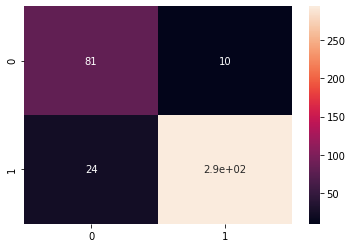

In [84]:
# Create and display confusin matrix for Naive Bayes Classificator
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True);

In [85]:
# Print the model prediction classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.77      0.89      0.83        91
           5       0.97      0.92      0.95       318

    accuracy                           0.92       409
   macro avg       0.87      0.91      0.89       409
weighted avg       0.92      0.92      0.92       409



# GRADINET BOOSTING CLASSIFIER

In [98]:
# Create Gradient Boosting Model for test
from sklearn.ensemble import GradientBoostingClassifier as XGB
classifer_XGB = XGB(loss='deviance', learning_rate=1, n_estimators=60)
classifer_XGB.fit(X_train, y_train)
y_pred_xgb = classifer_XGB.predict(X_test)

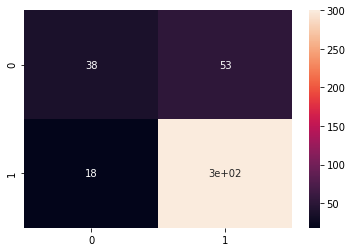

In [99]:
# Create and display confusin matrix for Gradient Boosting Classificator
conf_matrix_2 = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_2, annot=True);

In [100]:
# Print the report of Gradient Boosting Classfier 
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           1       0.68      0.42      0.52        91
           5       0.85      0.94      0.89       318

    accuracy                           0.83       409
   macro avg       0.76      0.68      0.71       409
weighted avg       0.81      0.83      0.81       409

